**PRÁCTICA 1**

El objetivo de esta práctica es entrenar dos modelos, uno con regresión logistica y otro con un arbol de decisión y comparar los resultados de ambos.
Los datos usados son un conjunto de información sobre casos de infarto.

Primero vamos a importar las librerias que se han usado

In [76]:
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score
from sklearn.metrics import det_curve
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from collections import Counter
import matplotlib.pyplot as plt
import  pandas as pd
import numpy as np

**PARTE 1. PROCESADO DE LOS DATOS**

el siguiente paso es comenzar a subir los datos y conocerlos (los datos deberian estar junto con la entrega)

In [3]:
lectura = pd.read_csv('datos_infarto.csv')
lectura.head()

,ID,Genero,Tipo_Trabajo,Residencia_habitual,Casado,Edad,Hipertension,Enfermedad_Corazon,Fumador,Nivel_medio_glucosa,IMC,Infarto
0,1,Hombre,Autonomo,Ciudad,Si,80.0,0,1,Fumo en el pasado,252.72,30.5,1
1,2,Hombre,Funcionario,Ciudad,No,48.0,0,0,Nunca ha fumado,84.20,29.7,1
2,3,Mujer,Sector Privado,Rural,No,82.0,1,1,Fumo en el pasado,84.03,26.5,1
3,4,Hombre,Sector Privado,Rural,Si,74.0,0,0,Fumo en el pasado,219.72,33.7,1
4,5,Mujer,Sector Privado,Rural,Si,72.0,1,0,Fumo en el pasado,74.63,23.1,1


En un primer análisis podemos ver varias cosas que nos pueden chirriar, por lo general la columna de id la eliminamos para evitar problemas (de hecho en este caso es esencial ya que la columna de id en este caso es identificativa de cada enfermedad por lo que si la usamos, nuestro clasificador simplemente aprendera esta norma)

In [7]:
lectura = lectura.drop(['ID'], axis=1)

Antes de continuar vamos a dejar ya separados los labels y nuestros datos para trabajar sobre ellos

In [9]:
y = lectura['Infarto']
x = lectura.drop(['Infarto'], axis=1)

Después algo muy importante que salta a la vista es el tipo de datos que tenemos, vamos a comprobarlo aunque a simple vista lo veamos

In [10]:
lectura.dtypes

Genero                  object
Tipo_Trabajo            object
Residencia_habitual     object
Casado                  object
Edad                   float64
Hipertension             int64
Enfermedad_Corazon       int64
Fumador                 object
Nivel_medio_glucosa    float64
IMC                    float64
Infarto                  int64
dtype: object

observamos como tenemos varias columnas de tipo object que no podremos meter de manera directa a nuestro clasificador, la mejor manera de abordar esto es con la función de dummies que nos convierte cada columna con valor object en diferentes columnas con valores binarios para cada posibilidad, viendolo se entiende mejor

In [11]:
columnas_a_dummies = ['Genero','Tipo_Trabajo','Residencia_habitual','Casado','Fumador'] #elegimos las columnas que queremos transformar
df_dummies = pd.get_dummies(x, columns=columnas_a_dummies) #las transformamos y las metemos en el nuevo dataframe
colnomod = ['Edad','Hipertension','Enfermedad_Corazon','Nivel_medio_glucosa','IMC']
df_dummies[colnomod] = x[colnomod] #introducimos el resto de columnas en e nuevo dataframe
df_dummies.head()

,Edad,Hipertension,Enfermedad_Corazon,Nivel_medio_glucosa,IMC,Genero_Hombre,Genero_Mujer,Tipo_Trabajo_Autonomo,Tipo_Trabajo_Funcionario,Tipo_Trabajo_Menor,Tipo_Trabajo_Sector Privado,Residencia_habitual_Ciudad,Residencia_habitual_Rural,Casado_No,Casado_Si,Fumador_Fuma,Fumador_Fumo en el pasado,Fumador_No Contesta,Fumador_Nunca ha fumado
0,80.0,0,1,252.72,30.5,1,0,1,0,0,0,1,0,0,1,0,1,0,0
1,48.0,0,0,84.20,29.7,1,0,0,1,0,0,1,0,1,0,0,0,0,1
2,82.0,1,1,84.03,26.5,0,1,0,0,0,1,0,1,1,0,0,1,0,0
3,74.0,0,0,219.72,33.7,1,0,0,0,0,1,0,1,0,1,0,1,0,0
4,72.0,1,0,74.63,23.1,0,1,0,0,0,1,0,1,0,1,0,1,0,0


de manera sencilla vemos como para cada columna ahora tenemos las diferentes posibilidades en 1 y 0

este siguiente paso es opcional pero casi siempre recomendable hacerlo, que es normalizar o escalar los datos para que todos esten entre 0 y 1, esto facilita la interpretación de los datos. Lo hacemos de manera sencilla con la funcion minmax()

In [13]:
min_max_scaler = MinMaxScaler()
data_min_max = min_max_scaler.fit_transform(df_dummies)
data_min_max_df = pd.DataFrame(data_min_max, columns=df_dummies.columns)
data_min_max_df.head()

,Edad,Hipertension,Enfermedad_Corazon,Nivel_medio_glucosa,IMC,Genero_Hombre,Genero_Mujer,Tipo_Trabajo_Autonomo,Tipo_Trabajo_Funcionario,Tipo_Trabajo_Menor,Tipo_Trabajo_Sector Privado,Residencia_habitual_Ciudad,Residencia_habitual_Rural,Casado_No,Casado_Si,Fumador_Fuma,Fumador_Fumo en el pasado,Fumador_No Contesta,Fumador_Nunca ha fumado
0,0.975586,0.0,1.0,0.912196,0.472779,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,0.584961,0.0,0.0,0.134244,0.449857,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,1.000000,1.0,1.0,0.133460,0.358166,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
3,0.902344,0.0,0.0,0.759856,0.564470,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
4,0.877930,1.0,0.0,0.090066,0.260745,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0


Ya tenemos nuestros datos separados, transformados y normalizados, el ultimo paso es comprobar que no tenemos ningun dato vacío o null

In [14]:
data_min_max_df.isnull().sum()

Edad                           0
Hipertension                   0
Enfermedad_Corazon             0
Nivel_medio_glucosa            0
IMC                            0
Genero_Hombre                  0
Genero_Mujer                   0
Tipo_Trabajo_Autonomo          0
Tipo_Trabajo_Funcionario       0
Tipo_Trabajo_Menor             0
Tipo_Trabajo_Sector Privado    0
Residencia_habitual_Ciudad     0
Residencia_habitual_Rural      0
Casado_No                      0
Casado_Si                      0
Fumador_Fuma                   0
Fumador_Fumo en el pasado      0
Fumador_No Contesta            0
Fumador_Nunca ha fumado        0
dtype: int64

Con esto hemos terminado el procesado de nuestros datos por lo que podemos entrar en la segunda parte, el entrenamiento

**PARTE 2. ENTRENAMIENTO**

El primer paso antes de comenzar con los entrenamientos es dividir nuestros datos en train y test (en este caso no usaremos validación), para esto sklearn tiene una función que nos permite hacerlo de manera directa, vamos a mantener un 15% para nuestros datos de test

In [15]:
x_train, x_test, y_train, y_test = train_test_split(data_min_max_df, y, test_size=0.15, random_state=42)#para mantener los mismos resultados dejamos el random state en 42 por ejemplo

vamos a comprobar los tamaños


In [16]:
print(x_train.shape)
print(x_test.shape)

(4236, 19)
(748, 19)


Una vez tenemos nuestros datos separados tenemos que comprobar una ultima cosa y que sera esencial en este problema, y es comprobar si los datos estan balanceados, es decir si tenemos un numero parecido de casos de infarto y de no infarto

In [17]:
y.value_counts()

0    4734
1     250
Name: Infarto, dtype: int64

Vemos que esta muy desbalanceado, algo que es de entener al ser unos datos de infarto, es mas común no tenerlo, para evitar problemas con nuestro entrenamiento y poder evitar todo lo posible un overfitting, podemos realizar un undersampling o un oversampling, aunque en este caso los dos arrojan unos resultados parecidos vamos a realizar un oversmapling para la regresión logistica y un undersampling para el arbol de decision (recordar que esto es solo para el entrenamiento)

In [20]:
oversample = RandomOverSampler(sampling_strategy='minority', random_state=42)
undersample = RandomUnderSampler(sampling_strategy='majority', random_state=42)
x_under, y_under = undersample.fit_resample(x_train, y_train)
x_over, y_over = oversample.fit_resample(x_train, y_train)
print(y_over.value_counts())

1    4030
0    4030
Name: Infarto, dtype: int64


tenemos todo preparado para entrenar nuestros modelos asi que vamos con ellos

PARTE 2.1 LOGISTIC REGRESSION

Vamos a crearnos una clase con este clasificador, sklearn nos permite hacer los entrenamientos de manera muy sencilla

In [21]:
def LR (x_train, y_train):
    lr = LogisticRegression() #es una LR basica, para este problema no necesitamos ajustar mucho mas los hiperparametros aunque en practicas mas avanzadas necesitaremos usar un grid search o derivados
    lr.fit(x_train, y_train)#entrenamiento
    y_pred = lr.predict(x_test)#test
    return y_pred#devolver los resultados

Vamos a crear nuestro modelo y entrenarlo

In [25]:
model = LR(x_over, y_over)

como segundo paso deberiamos crear una clase con las metricas para poder evaluar nuestro modelo comparando los labels de test y los de la predicción, en este caso he seleccionado: El error medio, la accuracy, el F1 score, Matriz de confusión (normalizada para entender mejor debido al desbalance), y el recall. Sklearn nos permite hacer esto de manera muy sencilla. Para esta practica he omitido metricas como la ROC curve que en practicas posteriores si usaremos

In [26]:
def metrics(y_test,y_pred):
    err= np.mean(np.abs(y_test-y_pred))
    print(f'Error: {err}')
    acc = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {acc}')
    F1 = f1_score(y_test, y_pred, average='weighted')
    print(f'F1: {F1}')
    rec = recall_score(y_test, y_pred)
    print(f'Recall: {rec}')
    conf = confusion_matrix(y_test, y_pred, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=conf)
    disp.plot()
    plt.show()

vamos a comprobar que tal le ha ido a nuestro modelo

Error: 0.23663101604278075
Accuracy: 0.7633689839572193
F1: 0.8245944767797072
Recall: 0.8181818181818182


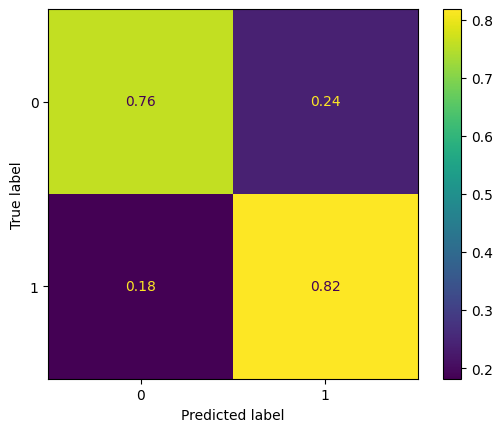

In [27]:
metrics(y_test, model)

pese a que no hemos obtenido unos resultados escandalosos no los podemos llamar malos, y mas teniendo en cuenta que no hemos ajustado ningun hiperparámetro. La matriz de confusion nos deja ver que nuestro modelo es mejor acertando casos de infarto algo que para este contexto es lo mejor. para el resto de datos:

Error: El error (0.2366) es una métrica que mide la proporción de predicciones incorrectas en relación con el número total de predicciones. En este caso, parece que alrededor del 23.66% de las predicciones del modelo son incorrectas.

Accuracy: La precisión (0.7634) es la métrica que mide la proporción de predicciones correctas en relación con el número total de predicciones. En este caso, el 76.34% de las predicciones son correctas.

Recall: El recall (sensibilidad) (0.8182) mide la proporción de casos positivos reales que el modelo ha identificado correctamente. En este caso, el modelo ha identificado correctamente el 81.82% de los casos positivos.

F1-Score: El socore F1 (0.8246) es una métrica que combina la precisión y la sensibilidad en un solo valor. Cuanto más cercano a 1 sea el puntaje F1, mejor será el equilibrio entre precisión y sensibilidad. En este caso, el modelo tiene un puntaje F1 bastante alto, lo que indica un buen rendimiento general.



PARTE 2.2 ARBOL DE DECISIÓN

De igual manera que con la LR sklearn nos permite realizar esto de manera sencilla, vamos a crearnos un clase

In [74]:
def Dt (x_train, y_train):
    clf = tree.DecisionTreeClassifier(random_state=42, max_depth=5) #en este caso he modificado la profundidad maxima ya que no tenemos un conjunto de datos enorme
    clf.fit(x_train, y_train)#entrenamos
    y_pred = clf.predict(x_test)#test
    return y_pred#devolvemos resultados

Vamos a crear nuestro modelo y vemos las metricas

Error: 0.29812834224598933
Accuracy: 0.7018716577540107
F1: 0.7806939516107841
Recall: 0.7272727272727273


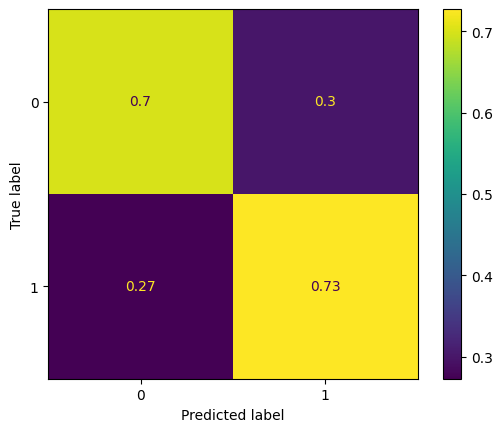

In [75]:
model2 = Dt(x_under, y_under)
metrics(y_test, model2)

Al igual que con la LR no son un resultados espectaculares pero esta claro que podrian ser peor, en este caso la matriz de conf nos muestra como es algo mejor prediciendo infartos, vamos a hacer un resumen de los resultados y comparamos los dos:

Error: 0.29812834224598933: El error, en este caso, indica que aproximadamente el 29.81% de las predicciones del modelo son incorrectas.

Accuracy: 0.7018716577540107: En este caso, el 70.19% de las predicciones del modelo son correctas.

Recall: 0.7272727272727273: En este caso, el modelo ha identificado correctamente el 72.73% de los casos positivos.

F1: 0.7806939516107841: En este caso, el modelo tiene un puntaje F1 de aproximadamente 0.781, lo que indica un buen equilibrio entre la precisión y la capacidad del modelo para identificar correctamente casos positivos.




**PARTE 3. COMPARACIÓN Y ELECCIÓN DEL MODELO**

Aqui debo hacer un disclaimer y es que esta comparación no es universal, es decir la eleccion no es universal, es muy probable que haciendo un search de los parametros los resultados sena totalmente diferentes y la eleccion del tipo de modelo cambie.

**Regresión Logística** (Primer Modelo):

> **Error:** 0.23663101604278075

> **Accuracy:** 0.7633689839572193

> **F1:** 0.8245944767797072

> **Recall:** 0.8181818181818182

**Árbol de Decisión** (Segundo Modelo):

> **Error:** 0.29812834224598933

> **Accuracy:** 0.7018716577540107

> **F1:** 0.7806939516107841

> **Recall:** 0.7272727272727273

Creo que la comparación es evidente, excepto en el F1 score la LR es de media un 10% mejor que el Arbol en este caso, y el F1 alrededor del 5%. Además si nos fijabamos en las matirces de confusion la mejora del 10% es simetrica (incluso algo mas del 10%) ya que la precision aumentaba tanto para los casos de infarto como para los del no infarto en incrementos parecidos.

En este experimento la elección es evidente: El modelo de regresión logística nos arroja mejores resultados